## SVM 

In dit notebook wordt een SVM model gefit op de metadata zonder tekst. In het script cleanup.ipynb zijn verschillende csv bestanden gemaakt die verschillende groepen metadata bevatten. In dit script worden deze afzonderlijke csv's gebruikt om te kijken hoe de prestaties onderling verschillen. 

Vervolgens worden de csv's uit feature_selection.ipynb gebruikt om mee te vergelijken. 

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, classification_report
from sklearn.inspection import permutation_importance

In [2]:
all_data = pd.read_csv('../../data/cleaned_data/all_columns.csv')

In [3]:
# drop all text columns to keep only metadata without text
all_data = all_data.drop(['full_text', 'user_description', 'username'], axis = 1)

In [4]:
def RandomSearchSVM(data):
    """Splits the data into x_train, x_test, y_train, y_test, performs a randomsearch on SVM and calculates the accuracy score using
       the best parameters."""
       
    # select x and y from data
    y = data.pop('real_fake_grade')
    x = data
    x = StandardScaler().fit_transform(x)

    # split into train and test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

    # perform Random Search with 7-fold CV and scoring on accuracy
    svm_rs = RandomizedSearchCV(SVC(), 
                          param_distributions = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                                'C': [0.5, 1, 1.5, 2]},
                          cv = 7,
                          scoring = make_scorer(accuracy_score)) 

    # fit the model
    svm_rs.fit(x_train, y_train)
    print('Best parameters:\n', svm_rs.best_params_)
    print()

    # make prediction with best parameters
    y_pred = svm_rs.best_estimator_.predict(x_test)

     # calculate accuracy score, precision and recall
    print('Accuracy score:', accuracy_score(y_test, y_pred))
    print('precision score:', precision_score(y_test, y_pred, average = 'macro')) # unweighted mean of all classes
    print('recall score:', recall_score(y_test, y_pred, average = 'macro')) # unweighted mean of all classes

    # classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    

#### 1. Alle metadata

In [5]:
RandomSearchSVM(all_data)

Best paramaters:
 {'kernel': 'rbf', 'C': 1}

Accuracy score: 0.7343453510436433


#### 2. Tweet_data_columns


In [7]:
tweet_data = pd.read_csv('../../data/cleaned_data/tweet_data_columns.csv')

In [8]:
tweet_data = tweet_data.drop('Unnamed: 0', axis = 1)

In [9]:
RandomSearchSVM(tweet_data)

Best paramaters:
 {'kernel': 'rbf', 'C': 2}

Accuracy score: 0.6584440227703985


#### 3. User_data_columns

De random search op user_data levert geen resultaat op, hij blijft maar door runnen. Daarom is er een voorspelling gemaakt met de standaardinstellingen van de SVM. 

In [2]:
user_data = pd.read_csv('../../data/cleaned_data/user_data_columns.csv')

In [3]:
user_data = user_data.drop('Unnamed: 0', axis = 1)

In [4]:
y = user_data.pop('real_fake_grade')
x = user_data
x = StandardScaler().fit_transform(x)

# split into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

In [5]:
svm_user = SVC().fit(x_train, y_train)
y_pred = svm_user.predict(x_test)

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

              precision    recall  f1-score      support
-1.0           0.689655  0.467091  0.556962   471.000000
0.0            0.750000  0.016484  0.032258   182.000000
1.0            0.678060  0.919181  0.780421   928.000000
accuracy       0.680582  0.680582  0.680582     0.680582
macro avg      0.705905  0.467585  0.456547  1581.000000
weighted avg   0.689796  0.680582  0.627723  1581.000000


## Resultaten op data met feature selection

De datasets die hieronder gebruikt worden zijn afkomstig van het script feature_selection.ipynb.

### All data selected

In [6]:
all_data_selected = pd.read_csv('../../data/selected_data/all_data_selected.csv')
all_data_selected = all_data_selected.drop([ 'Unnamed: 0', 'full_text', 'user_description', 'username'], axis = 1)


In [7]:
RandomSearchSVM(all_data_selected)

Best parameters:
 {'kernel': 'rbf', 'C': 1.5}

Accuracy score: 0.7216951296647691
precision score: 0.6465429845904298
recall score: 0.5248601667995474
              precision    recall  f1-score      support
-1.0           0.710462  0.619958  0.662132   471.000000
0.0            0.500000  0.049451  0.090000   182.000000
1.0            0.729167  0.905172  0.807692   928.000000
accuracy       0.721695  0.721695  0.721695     0.721695
macro avg      0.646543  0.524860  0.519941  1581.000000
weighted avg   0.697213  0.721695  0.681709  1581.000000


#### Permutation Importance

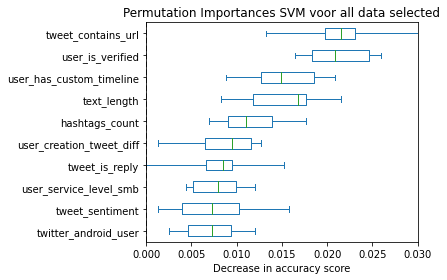

In [3]:
all_data_selected = pd.read_csv('../../data/selected_data/all_data_selected.csv')
all_data_selected = all_data_selected.drop([ 'Unnamed: 0', 'full_text', 'user_description', 'username'], axis = 1)

# select x and y from data
y = all_data_selected.pop('real_fake_grade')
x = all_data_selected
x = StandardScaler().fit_transform(x)

# split into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y)

model = SVC(kernel = 'rbf', C=2).fit(x_train, y_train) # zelfde parameter waarden als uit _best_params_ van randomsearch

result = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2,
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=all_data_selected.columns[sorted_importances_idx],
)

importances = importances.iloc[:,30:]

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances SVM voor all data selected")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.xlim(0,0.03)

plt.show()

### Tweet data selected

In [7]:
tweet_data_selected = pd.read_csv('../../data/selected_data/tweet_data_selected.csv')
RandomSearchSVM(tweet_data_selected)


Best parameters:
 {'kernel': 'rbf', 'C': 1.5}

Accuracy score: 0.6913345983554712
precision score: 0.608722971049472
recall score: 0.49697117178036354
              precision    recall  f1-score      support
-1.0           0.662304  0.537155  0.593200   471.000000
0.0            0.458333  0.060440  0.106796   182.000000
1.0            0.705532  0.893319  0.788398   928.000000
accuracy       0.691335  0.691335  0.691335     0.691335
macro avg      0.608723  0.496971  0.496131  1581.000000
weighted avg   0.664197  0.691335  0.651782  1581.000000


### User data selected

In [8]:
user_data_selected = pd.read_csv('../../data/selected_data/user_data_selected.csv')
RandomSearchSVM(user_data_selected)

Best parameters:
 {'kernel': 'rbf', 'C': 2}

Accuracy score: 0.7216951296647691
precision score: 0.6588042508986275
recall score: 0.5130461235021415
              precision    recall  f1-score      support
-1.0           0.766017  0.583864  0.662651   471.000000
0.0            0.500000  0.027473  0.052083   182.000000
1.0            0.710396  0.927802  0.804673   928.000000
accuracy       0.721695  0.721695  0.721695     0.721695
macro avg      0.658804  0.513046  0.506469  1581.000000
weighted avg   0.702746  0.721695  0.675727  1581.000000
